In [19]:
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [20]:
matrix_file = Path.cwd() / "runs" / "aha-mont64-fb8c96bc" / "n_10000" / "bbv.matrix"
with matrix_file.open('rb') as f:
    matrix = pickle.load(f)
matrix = normalize(matrix)
print(matrix.shape)

(193, 93)


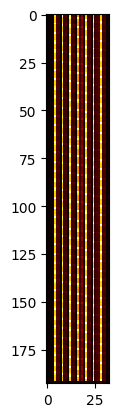

In [21]:
# Show a heatmap
plt.imshow(matrix[:200,17:50], cmap='hot', interpolation='nearest')

In [22]:
# Perform clustering
kmeans = KMeans(n_clusters=12, n_init='auto', verbose=100, random_state=100)
kmeans.fit(matrix)

Initialization complete
Iteration 0, inertia 0.417855357835615.
Iteration 1, inertia 0.3382289700838888.
Iteration 2, inertia 0.3278336363547648.
Iteration 3, inertia 0.32431215048250145.
Iteration 4, inertia 0.32384575949216377.
Converged at iteration 4: strict convergence.


KMeans(n_clusters=12, n_init='auto', random_state=100, verbose=100)

In [23]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids.shape, labels.shape)

(12, 93) (193,)


In [24]:
sample_idxs = []
for label_idx in range(centroids.shape[0]):
    sample_idxes_near_cluster = np.argwhere(labels == label_idx).flatten()
    samples_near_cluster = matrix[sample_idxes_near_cluster,:]
    dists_from_centroid = np.linalg.norm(np.subtract(samples_near_cluster, centroids[label_idx]), axis=1)
    closest_sample_idx = np.argmin(dists_from_centroid)
    matrix_sample_idx = sample_idxes_near_cluster[closest_sample_idx]
    sample_idxs.append(matrix_sample_idx)

In [25]:
# Attempt to reconstruct IPC trace
gold_ipc_file = Path.cwd().parent.parent / "sims" / "vcs" / "aha-mont64_perf.csv"
gold_ipc = pd.read_csv(gold_ipc_file)
kmeans_model_file = Path.cwd() / "runs" / "aha-mont64-fb8c96bc" / "n_10000" / "c_12" / "kmeans.model"
with kmeans_model_file.open('rb') as f:
    kmeans_model = pickle.load(f)

In [37]:
# For every centroid sample, get the average IPC, excluding the first sample (consider the first 100 cycles as detailed warmup)
perf_files = [Path.cwd() / "runs" / "aha-mont64-fb8c96bc" / "n_10000" / "c_12" / "checkpoints" / "aha-mont64.loadarch" / f"0x80000000.{x*10000}" / "perf.csv" for x in sample_idxs]
sample_ipc_trace = []
for perf_file in perf_files:
    ipc_trace = pd.read_csv(perf_file)
    assert (ipc_trace['instret'].to_numpy()[:-1] == 1000).all()
    sample_ipc_trace.append(1000 / np.mean(ipc_trace['cycles'][1:-1]))

In [38]:
# Reconstruct the IPC trace from the labels for each sample
x_coords = []
y_coords = []
i = 0
for label in labels:
    x_coords.append(i)
    ipc = sample_ipc_trace[label]
    y_coords.append(ipc)
    x_coords.append(i+10000-1)
    y_coords.append(ipc)
    i = i + 10000

In [39]:
gold_x = []
gold_y = []
i = 0
for cycles in gold_ipc['cycles']:
    gold_x.append(i)
    gold_y.append(1000 / cycles)
    gold_x.append(i+1000-1)
    gold_y.append(1000 / cycles)
    i = i + 1000

In [40]:
gold_ipc

,cycles,instret
0,3338,1000
1,1364,1000
2,1269,1000
3,1263,1000
4,1561,1000
...,...,...
1916,1201,1000
1917,1182,1000
1918,1198,1000
1919,1352,1000


(500000.0, 600000.0, 0.4, 1.0)

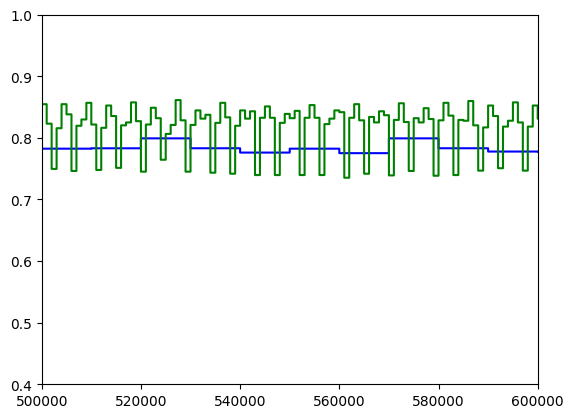

In [44]:
plt.plot(x_coords, y_coords, 'b')
plt.plot(gold_x, gold_y, 'g')
plt.axis([0.5e6, 0.6e6, 0.4, 1])